# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'NeuralNetwork'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

pictures_results_path = results_path+'/'+analysis_name+'/pictures_files'
files_results_path = results_path+'/'+analysis_name+'/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag   = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    file_name = '%s/%s/lofar_data_file_fft_%s_decimation_%s_spectrum_left_%s.jbl'%(data_path,
                                                                                  database,
                                                                                  n_pts_fft,
                                                                                  decimation_rate,
                                                                                  spectrum_bins_left)
  
    [data,trgt,class_labels] = joblib.load(file_name)
    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 2.31266021729e-05 seconds
Time to read data file: 1.02969503403 seconds


Using Theano backend.


Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


# Train process
## The train will modify one file and create three different files

### Log File:
This file will store basic information of all Package's trains and it will guide the analyses file to recognize which train information file should load. In each train this file should be appended with a new line contend the basic information to find the train information file (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis

### Train Information File
This file will store full information of the train performed (all parameters) in its name (each train information file will have a different name). And it will guide which train classifier file or which train result file should be open for analysis (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis

### Train Result File
This file will store the classifier result for all data and classification target (TXT FORMAT) or (PYTHON FORMAT) - This file should be access by all programs (MatLab and Python) for Analysis


In [2]:
%time

from sklearn import cross_validation
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry("Classification",'NeuralNetwork')

# Create a train information file
n_folds = 4
n_inits = 4
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['norm'] = norm

# divide data in train and test for novelty detection
print 'Dividing data in train and test'
CVO = cross_validation.StratifiedKFold(all_trgt, n_folds)
CVO = list(CVO)
train_info['CVO'] = CVO

train_info['preprocessing_extraction_done'] = False
train_info['preprocessing_analysis_done'] = False
train_info['train_done'] = False
train_info['results_done'] = False
train_info['dev'] = development_flag
train_info['n_neurons'] = None

train_info_name = files_results_path+'/'+date+'_train_info.jbl'
joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
Dividing data in train and test


/home/vinicius.mello/.virtualenvs/sonarenvAnnecy/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


['/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/NeuralNetwork/output_files/2017_08_07_11_05_17_train_info.jbl']

In [6]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="Classification")
lastTrain = log_entries[np.max(log_entries.keys())]
print 'Last Train\nDate: {0}\nPackage: {1}\n'.format(lastTrain['date'],lastTrain['package'])
for ilog in log_entries.values():
    if ilog['package'] == analysis_name:
        print ilog

Last Train
Date: 2017_08_07_11_05_17
Package: NeuralNetwork

{'date': '2017_07_21_15_28_43', 'package': 'NeuralNetwork'}
{'date': '2017_07_21_16_13_33', 'package': 'NeuralNetwork'}
{'date': '2017_07_23_11_11_41', 'package': 'NeuralNetwork'}
{'date': '2017_07_24_14_09_20', 'package': 'NeuralNetwork'}
{'date': '2017_07_24_23_54_53', 'package': 'NeuralNetwork'}
{'date': '2017_07_25_19_38_23', 'package': 'NeuralNetwork'}
{'date': '2017_07_26_09_48_39', 'package': 'NeuralNetwork'}
{'date': '2017_07_26_12_47_25', 'package': 'NeuralNetwork'}
{'date': '2017_07_27_00_28_29', 'package': 'NeuralNetwork'}
{'date': '2017_07_27_01_09_30', 'package': 'NeuralNetwork'}
{'date': '2017_07_27_20_45_24', 'package': 'NeuralNetwork'}
{'date': '2017_07_28_00_10_04', 'package': 'NeuralNetwork'}
{'date': '2017_07_28_09_33_56', 'package': 'NeuralNetwork'}
{'date': '2017_07_28_22_22_25', 'package': 'NeuralNetwork'}
{'date': '2017_07_29_01_19_00', 'package': 'NeuralNetwork'}
{'date': '2017_07_29_20_02_39', 'packag

In [7]:
# Read Information of Train Info File
choose_date = '2017_08_07_11_05_17'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'NeuralNetwork':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = files_results_path+'/'+log_entries[log_id]['date']+'_train_info.jbl'
    [train_info] = joblib.load(train_info_name)
    print 'NeuralNetwork Train Info File'
    print 'Date: %s'%(choose_date)
    print 'Number of Folds: %i'%(train_info['n_folds'])
    print 'Number of Inits: %i'%(train_info['n_inits'])
    if train_info['n_neurons'] is not None: print 'Number of Neurons: %i'%train_info['n_neurons']
    print 'Normalization Method: %s'%(train_info['norm'])
    if train_info['preprocessing_extraction_done']:
        print 'Preprocessing Extraction Done: True'
    else:
        print 'Preprocessing Extraction Done: False'
    if train_info['preprocessing_analysis_done']:
        print 'Preprocessing Analysis Done: True'
    else:
        print 'Preprocessing Analysis Done: False'
    if train_info['train_done']:
        print 'Train Done: True'
    else:
        print 'Train Done: False'
    if train_info['results_done']:
        print 'Extract Results: True'
    else:
        print 'Extract Results: False'

Analysing train performed in 2017_08_07_11_05_17 and for NeuralNetwork analysis
NeuralNetwork Train Info File
Date: 2017_08_07_11_05_17
Number of Folds: 4
Number of Inits: 4
Normalization Method: mapstd
Preprocessing Extraction Done: False
Preprocessing Analysis Done: False
Train Done: False
Extract Results: False


In [8]:
# Train Process
from Functions import LogFunctions as log
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
import keras.callbacks as callbacks
from keras.utils import np_utils

from datetime import datetime  
from datetime import timedelta 

train_info_name = files_results_path+'/'+choose_date+'_train_info.jbl'
[train_info] = joblib.load(train_info_name)

# try to estimate time to be done...
total_trains = train_info['n_folds']*train_info['n_inits']

nn_trained = 0 

# Parameters of the model
n_neurons    = 30
# Parameters of Optimizer Algorithm
learningRate = 0.005
beta_1       = 0.9
beta_2       = 0.999
epsilon      = 1e-08
# Parameters of the training
nb_epochs    = 500
batch_size   = 1024
if not train_info['train_done']:
    for ifold in range(train_info['n_folds']):
        train_id, test_id = CVO[ifold]

        classifiers = []
        trn_desc = {}

        # normalize data based in train set
        if train_info['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_all_data = scaler.transform(all_data)

        print 'Train Process for %i Fold of %i Folds'%(ifold+1,train_info['n_folds'] )

        best_init = 0
        best_loss = 999

        for i_init in range(train_info['n_inits']):
            print 'Init: %i of %i'%(i_init+1,train_info['n_inits'])
            model = Sequential()
            model.add(Dense(n_neurons, input_dim=all_data.shape[1], init="uniform"))
            model.add(Activation('softplus'))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation('softmax'))

            adam = Adam(lr=learningRate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

            model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

            # Train model
            earlyStopping = callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=25,
                                                    verbose=1,
                                                    mode='auto')
            start_time = time.time()
            init_trn_desc = model.fit(norm_all_data[train_id], trgt_sparse[train_id], 
                                    nb_epoch=nb_epochs, 
                                    batch_size=batch_size,
                                    callbacks=[earlyStopping], 
                                    verbose=True,
                                    validation_data=(all_data[test_id],trgt_sparse[test_id]),
                                    shuffle=True)
            end_time = time.time()
            train_time = end_time-start_time
            nn_trained += 1

            now = datetime.now()
            finish_time  = now + timedelta(seconds = (total_trains-nn_trained)*train_time)

            print 'Estimated Finish Time: %s'%(
            finish_time.strftime("%Y/%m/%d-%H:%M:%S"))
            if np.min(init_trn_desc.history['val_loss']) < best_loss:
                best_init = i_init
                best_loss = np.min(init_trn_desc.history['val_loss'])
                classifiers = model
                trn_desc['epochs'] = init_trn_desc.epoch
                trn_desc['acc'] = init_trn_desc.history['acc']
                trn_desc['loss'] = init_trn_desc.history['loss']
                trn_desc['val_loss'] = init_trn_desc.history['val_loss']
                trn_desc['val_acc'] = init_trn_desc.history['val_acc']

        # save modeldate
        base_name = files_results_path+'/'+date+'_'
        save_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
        classifiers.save(save_file_name)
        save_file_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
        train_info['train_done'] = True
        joblib.dump([train_info,n_neurons,trn_desc],save_file_name,compress=9)
        train_info['n_neurons'] = n_neurons
        train_info_name = files_results_path+'/'+date+'_train_info.jbl'
        joblib.dump([train_info],train_info_name,compress=9)    
else:
    print 'Train %s is already done. Do the analysis!'%choose_date

Train Process for 1 Fold of 4 Folds
Init: 1 of 4
Train on 88056 samples, validate on 29352 samples
Epoch 1/500
88056/88056 [==============================] - 2s - loss: 0.1036 - acc: 0.6988 - val_loss: 0.1419 - val_acc: 0.6867
Epoch 2/500
88056/88056 [==============================] - 2s - loss: 0.0756 - acc: 0.7863 - val_loss: 0.1395 - val_acc: 0.6888
Epoch 3/500
88056/88056 [==============================] - 2s - loss: 0.0653 - acc: 0.8181 - val_loss: 0.1326 - val_acc: 0.7485
Epoch 4/500
88056/88056 [==============================] - 2s - loss: 0.0577 - acc: 0.8443 - val_loss: 0.1272 - val_acc: 0.7584
Epoch 5/500
88056/88056 [==============================] - 2s - loss: 0.0524 - acc: 0.8608 - val_loss: 0.1220 - val_acc: 0.7556
Epoch 6/500
88056/88056 [==============================] - 2s - loss: 0.0486 - acc: 0.8733 - val_loss: 0.1189 - val_acc: 0.7438
Epoch 7/500
88056/88056 [==============================] - 2s - loss: 0.0455 - acc: 0.8853 - val_loss: 0.1153 - val_acc: 0.7402
Epoch

88056/88056 [==============================] - 2s - loss: 0.0306 - acc: 0.9302 - val_loss: 0.1147 - val_acc: 0.6759
Epoch 19/500
88056/88056 [==============================] - 2s - loss: 0.0298 - acc: 0.9330 - val_loss: 0.1177 - val_acc: 0.6639
Epoch 20/500
88056/88056 [==============================] - 3s - loss: 0.0292 - acc: 0.9344 - val_loss: 0.1159 - val_acc: 0.6690
Epoch 21/500
88056/88056 [==============================] - 3s - loss: 0.0286 - acc: 0.9360 - val_loss: 0.1164 - val_acc: 0.6645
Epoch 22/500
88056/88056 [==============================] - 3s - loss: 0.0283 - acc: 0.9370 - val_loss: 0.1160 - val_acc: 0.6649
Epoch 23/500
88056/88056 [==============================] - 3s - loss: 0.0279 - acc: 0.9380 - val_loss: 0.1171 - val_acc: 0.6642
Epoch 24/500
88056/88056 [==============================] - 3s - loss: 0.0273 - acc: 0.9399 - val_loss: 0.1176 - val_acc: 0.6590
Epoch 25/500
88056/88056 [==============================] - 3s - loss: 0.0268 - acc: 0.9409 - val_loss: 0.1192

88056/88056 [==============================] - 5s - loss: 0.0228 - acc: 0.9506 - val_loss: 0.0868 - val_acc: 0.7544
Epoch 39/500
88056/88056 [==============================] - 6s - loss: 0.0228 - acc: 0.9511 - val_loss: 0.0863 - val_acc: 0.7553
Epoch 40/500
88056/88056 [==============================] - 6s - loss: 0.0227 - acc: 0.9514 - val_loss: 0.0876 - val_acc: 0.7523
Epoch 41/500
88056/88056 [==============================] - 6s - loss: 0.0225 - acc: 0.9520 - val_loss: 0.0860 - val_acc: 0.7571
Epoch 42/500
88056/88056 [==============================] - 6s - loss: 0.0222 - acc: 0.9522 - val_loss: 0.0880 - val_acc: 0.7523
Epoch 43/500
88056/88056 [==============================] - 6s - loss: 0.0221 - acc: 0.9526 - val_loss: 0.0869 - val_acc: 0.7555
Epoch 44/500
88056/88056 [==============================] - 7s - loss: 0.0220 - acc: 0.9530 - val_loss: 0.0862 - val_acc: 0.7586
Epoch 45/500
88056/88056 [==============================] - 7s - loss: 0.0220 - acc: 0.9528 - val_loss: 0.0871

88056/88056 [==============================] - 5s - loss: 0.0240 - acc: 0.9482 - val_loss: 0.0985 - val_acc: 0.7174
Epoch 37/500
88056/88056 [==============================] - 5s - loss: 0.0238 - acc: 0.9485 - val_loss: 0.0976 - val_acc: 0.7225
Epoch 38/500
88056/88056 [==============================] - 5s - loss: 0.0236 - acc: 0.9488 - val_loss: 0.1009 - val_acc: 0.7121
Epoch 39/500
88056/88056 [==============================] - 6s - loss: 0.0234 - acc: 0.9497 - val_loss: 0.0994 - val_acc: 0.7160
Epoch 40/500
88056/88056 [==============================] - 6s - loss: 0.0228 - acc: 0.9512 - val_loss: 0.1013 - val_acc: 0.7109
Epoch 41/500
88056/88056 [==============================] - 6s - loss: 0.0227 - acc: 0.9513 - val_loss: 0.1027 - val_acc: 0.7079
Epoch 42/500
88056/88056 [==============================] - 6s - loss: 0.0227 - acc: 0.9515 - val_loss: 0.0994 - val_acc: 0.7176
Epoch 43/500
88056/88056 [==============================] - 6s - loss: 0.0226 - acc: 0.9517 - val_loss: 0.1010

88056/88056 [==============================] - 7s - loss: 0.0222 - acc: 0.9524 - val_loss: 0.0970 - val_acc: 0.7259
Epoch 46/500
88056/88056 [==============================] - 7s - loss: 0.0222 - acc: 0.9526 - val_loss: 0.0989 - val_acc: 0.7219
Epoch 47/500
88056/88056 [==============================] - 7s - loss: 0.0218 - acc: 0.9533 - val_loss: 0.1003 - val_acc: 0.7186
Epoch 48/500
88056/88056 [==============================] - 7s - loss: 0.0219 - acc: 0.9532 - val_loss: 0.0983 - val_acc: 0.7245
Epoch 49/500
88056/88056 [==============================] - 7s - loss: 0.0218 - acc: 0.9532 - val_loss: 0.1004 - val_acc: 0.7182
Epoch 50/500
88056/88056 [==============================] - 7s - loss: 0.0219 - acc: 0.9531 - val_loss: 0.1021 - val_acc: 0.7145
Epoch 51/500
88056/88056 [==============================] - 7s - loss: 0.0216 - acc: 0.9539 - val_loss: 0.0994 - val_acc: 0.7220
Epoch 52/500
88056/88056 [==============================] - 7s - loss: 0.0215 - acc: 0.9543 - val_loss: 0.0999

88056/88056 [==============================] - 7s - loss: 0.0219 - acc: 0.9531 - val_loss: 0.1142 - val_acc: 0.6805
Epoch 48/500
88056/88056 [==============================] - 7s - loss: 0.0220 - acc: 0.9529 - val_loss: 0.1147 - val_acc: 0.6800
Epoch 49/500
88056/88056 [==============================] - 7s - loss: 0.0218 - acc: 0.9539 - val_loss: 0.1133 - val_acc: 0.6827
Epoch 50/500
88056/88056 [==============================] - 7s - loss: 0.0216 - acc: 0.9540 - val_loss: 0.1169 - val_acc: 0.6768
Epoch 51/500
88056/88056 [==============================] - 8s - loss: 0.0216 - acc: 0.9537 - val_loss: 0.1139 - val_acc: 0.6831
Epoch 52/500
88056/88056 [==============================] - 8s - loss: 0.0216 - acc: 0.9538 - val_loss: 0.1173 - val_acc: 0.6755
Estimated Finish Time: 2017/08/07-12:11:48
Init: 3 of 4
Train on 88056 samples, validate on 29352 samples
Epoch 1/500
88056/88056 [==============================] - 2s - loss: 0.0970 - acc: 0.7236 - val_loss: 0.1461 - val_acc: 0.6750
Epoch

88056/88056 [==============================] - 2s - loss: 0.0372 - acc: 0.9092 - val_loss: 0.1127 - val_acc: 0.7150
Epoch 12/500
88056/88056 [==============================] - 2s - loss: 0.0361 - acc: 0.9129 - val_loss: 0.1097 - val_acc: 0.7185
Epoch 13/500
88056/88056 [==============================] - 2s - loss: 0.0347 - acc: 0.9177 - val_loss: 0.1085 - val_acc: 0.7141
Epoch 14/500
88056/88056 [==============================] - 2s - loss: 0.0337 - acc: 0.9203 - val_loss: 0.1088 - val_acc: 0.7030
Epoch 15/500
88056/88056 [==============================] - 2s - loss: 0.0326 - acc: 0.9235 - val_loss: 0.1061 - val_acc: 0.7140
Epoch 16/500
88056/88056 [==============================] - 2s - loss: 0.0318 - acc: 0.9265 - val_loss: 0.1044 - val_acc: 0.7146
Epoch 17/500
88056/88056 [==============================] - 2s - loss: 0.0309 - acc: 0.9287 - val_loss: 0.1035 - val_acc: 0.7134
Epoch 18/500
88056/88056 [==============================] - 2s - loss: 0.0303 - acc: 0.9309 - val_loss: 0.1021

88056/88056 [==============================] - 4s - loss: 0.0269 - acc: 0.9400 - val_loss: 0.0930 - val_acc: 0.7354
Epoch 28/500
88056/88056 [==============================] - 4s - loss: 0.0263 - acc: 0.9420 - val_loss: 0.0931 - val_acc: 0.7340
Epoch 29/500
88056/88056 [==============================] - 4s - loss: 0.0260 - acc: 0.9425 - val_loss: 0.0989 - val_acc: 0.7129
Epoch 30/500
88056/88056 [==============================] - 4s - loss: 0.0257 - acc: 0.9436 - val_loss: 0.0934 - val_acc: 0.7302
Epoch 31/500
88056/88056 [==============================] - 5s - loss: 0.0254 - acc: 0.9446 - val_loss: 0.0943 - val_acc: 0.7264
Epoch 32/500
88056/88056 [==============================] - 5s - loss: 0.0253 - acc: 0.9446 - val_loss: 0.0993 - val_acc: 0.7122
Epoch 33/500
88056/88056 [==============================] - 5s - loss: 0.0250 - acc: 0.9457 - val_loss: 0.0955 - val_acc: 0.7235
Epoch 34/500
88056/88056 [==============================] - 5s - loss: 0.0249 - acc: 0.9456 - val_loss: 0.0939

88056/88056 [==============================] - 6s - loss: 0.0238 - acc: 0.9489 - val_loss: 0.1045 - val_acc: 0.7004
Epoch 40/500
88056/88056 [==============================] - 6s - loss: 0.0232 - acc: 0.9503 - val_loss: 0.1031 - val_acc: 0.7052
Epoch 41/500
88056/88056 [==============================] - 6s - loss: 0.0235 - acc: 0.9496 - val_loss: 0.1023 - val_acc: 0.7065
Epoch 42/500
88056/88056 [==============================] - 7s - loss: 0.0235 - acc: 0.9495 - val_loss: 0.1042 - val_acc: 0.7028
Epoch 43/500
88056/88056 [==============================] - 7s - loss: 0.0236 - acc: 0.9490 - val_loss: 0.1064 - val_acc: 0.6963
Epoch 44/500
88056/88056 [==============================] - 7s - loss: 0.0233 - acc: 0.9497 - val_loss: 0.1075 - val_acc: 0.6940
Epoch 45/500
88056/88056 [==============================] - 7s - loss: 0.0232 - acc: 0.9500 - val_loss: 0.1071 - val_acc: 0.6955
Epoch 46/500
88056/88056 [==============================] - 7s - loss: 0.0232 - acc: 0.9504 - val_loss: 0.1080

88056/88056 [==============================] - 6s - loss: 0.0234 - acc: 0.9499 - val_loss: 0.0996 - val_acc: 0.7123
Epoch 43/500
88056/88056 [==============================] - 7s - loss: 0.0236 - acc: 0.9490 - val_loss: 0.0998 - val_acc: 0.7130
Epoch 44/500
88056/88056 [==============================] - 7s - loss: 0.0235 - acc: 0.9495 - val_loss: 0.0989 - val_acc: 0.7162
Epoch 45/500
88056/88056 [==============================] - 7s - loss: 0.0231 - acc: 0.9506 - val_loss: 0.0990 - val_acc: 0.7148
Epoch 46/500
88056/88056 [==============================] - 7s - loss: 0.0227 - acc: 0.9520 - val_loss: 0.1004 - val_acc: 0.7133
Epoch 47/500
88056/88056 [==============================] - 7s - loss: 0.0228 - acc: 0.9511 - val_loss: 0.1008 - val_acc: 0.7111
Epoch 48/500
88056/88056 [==============================] - 7s - loss: 0.0228 - acc: 0.9510 - val_loss: 0.1023 - val_acc: 0.7091
Epoch 49/500
88056/88056 [==============================] - 7s - loss: 0.0226 - acc: 0.9517 - val_loss: 0.1029

88056/88056 [==============================] - 7s - loss: 0.0229 - acc: 0.9511 - val_loss: 0.1042 - val_acc: 0.7054
Epoch 48/500
88056/88056 [==============================] - 7s - loss: 0.0229 - acc: 0.9511 - val_loss: 0.1026 - val_acc: 0.7112
Epoch 49/500
88056/88056 [==============================] - 7s - loss: 0.0228 - acc: 0.9514 - val_loss: 0.1056 - val_acc: 0.7015
Epoch 50/500
88056/88056 [==============================] - 7s - loss: 0.0227 - acc: 0.9511 - val_loss: 0.1031 - val_acc: 0.7090
Epoch 51/500
88056/88056 [==============================] - 7s - loss: 0.0230 - acc: 0.9506 - val_loss: 0.1069 - val_acc: 0.7022
Epoch 52/500
88056/88056 [==============================] - 8s - loss: 0.0228 - acc: 0.9511 - val_loss: 0.1061 - val_acc: 0.7030
Epoch 53/500
88056/88056 [==============================] - 8s - loss: 0.0226 - acc: 0.9517 - val_loss: 0.1052 - val_acc: 0.7071
Epoch 54/500
88056/88056 [==============================] - 8s - loss: 0.0225 - acc: 0.9518 - val_loss: 0.1052

88056/88056 [==============================] - 5s - loss: 0.0261 - acc: 0.9430 - val_loss: 0.1039 - val_acc: 0.7034
Epoch 35/500
88056/88056 [==============================] - 5s - loss: 0.0261 - acc: 0.9431 - val_loss: 0.1014 - val_acc: 0.7130
Epoch 36/500
88056/88056 [==============================] - 5s - loss: 0.0261 - acc: 0.9431 - val_loss: 0.1074 - val_acc: 0.6971
Epoch 37/500
88056/88056 [==============================] - 5s - loss: 0.0258 - acc: 0.9438 - val_loss: 0.1016 - val_acc: 0.7139
Epoch 38/500
88056/88056 [==============================] - 6s - loss: 0.0255 - acc: 0.9446 - val_loss: 0.1068 - val_acc: 0.6987
Epoch 39/500
88056/88056 [==============================] - 6s - loss: 0.0251 - acc: 0.9461 - val_loss: 0.1052 - val_acc: 0.7025
Epoch 40/500
88056/88056 [==============================] - 6s - loss: 0.0252 - acc: 0.9456 - val_loss: 0.1043 - val_acc: 0.7053
Epoch 41/500
88056/88056 [==============================] - 6s - loss: 0.0251 - acc: 0.9457 - val_loss: 0.1062

88056/88056 [==============================] - 7s - loss: 0.0237 - acc: 0.9497 - val_loss: 0.1075 - val_acc: 0.7035
Epoch 45/500
88056/88056 [==============================] - 7s - loss: 0.0237 - acc: 0.9495 - val_loss: 0.1051 - val_acc: 0.7122
Epoch 46/500
88056/88056 [==============================] - 7s - loss: 0.0242 - acc: 0.9479 - val_loss: 0.1049 - val_acc: 0.7130
Epoch 47/500
88056/88056 [==============================] - 7s - loss: 0.0238 - acc: 0.9487 - val_loss: 0.1051 - val_acc: 0.7138
Epoch 48/500
88056/88056 [==============================] - 7s - loss: 0.0236 - acc: 0.9494 - val_loss: 0.1062 - val_acc: 0.7117
Epoch 49/500
88056/88056 [==============================] - 8s - loss: 0.0235 - acc: 0.9497 - val_loss: 0.1052 - val_acc: 0.7142
Epoch 50/500
88056/88056 [==============================] - 8s - loss: 0.0236 - acc: 0.9495 - val_loss: 0.1040 - val_acc: 0.7176
Epoch 51/500
88056/88056 [==============================] - 8s - loss: 0.0234 - acc: 0.9500 - val_loss: 0.1040

88056/88056 [==============================] - 8s - loss: 0.0236 - acc: 0.9498 - val_loss: 0.1201 - val_acc: 0.6691
Epoch 53/500
88056/88056 [==============================] - 8s - loss: 0.0238 - acc: 0.9490 - val_loss: 0.1152 - val_acc: 0.6816
Epoch 54/500
88056/88056 [==============================] - 8s - loss: 0.0238 - acc: 0.9488 - val_loss: 0.1151 - val_acc: 0.6833
Epoch 55/500
88056/88056 [==============================] - 8s - loss: 0.0236 - acc: 0.9496 - val_loss: 0.1173 - val_acc: 0.6778
Epoch 56/500
88056/88056 [==============================] - 8s - loss: 0.0232 - acc: 0.9505 - val_loss: 0.1146 - val_acc: 0.6843
Epoch 57/500
88056/88056 [==============================] - 8s - loss: 0.0233 - acc: 0.9504 - val_loss: 0.1171 - val_acc: 0.6792
Epoch 58/500
88056/88056 [==============================] - 8s - loss: 0.0233 - acc: 0.9503 - val_loss: 0.1159 - val_acc: 0.6836
Estimated Finish Time: 2017/08/07-12:16:32
Init: 4 of 4
Train on 88056 samples, validate on 29352 samples
Epoc

##    Analysis of the model trained

Results for fold #0
Results for fold #1
Results for fold #2
Results for fold #3


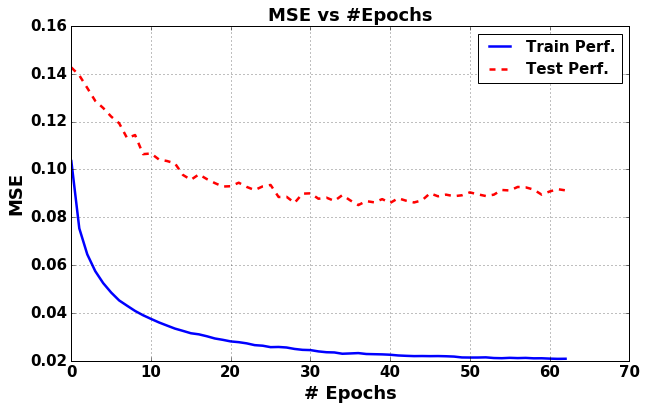

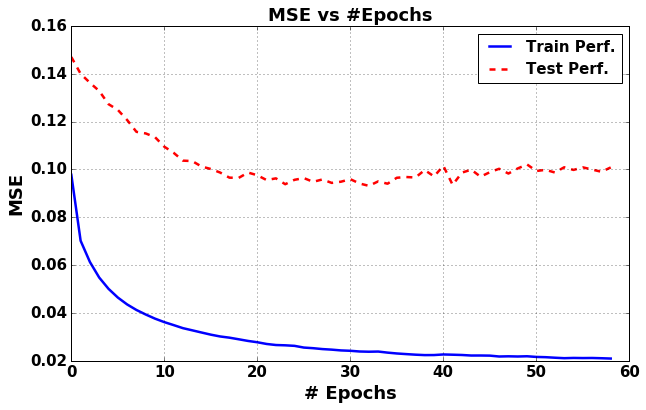

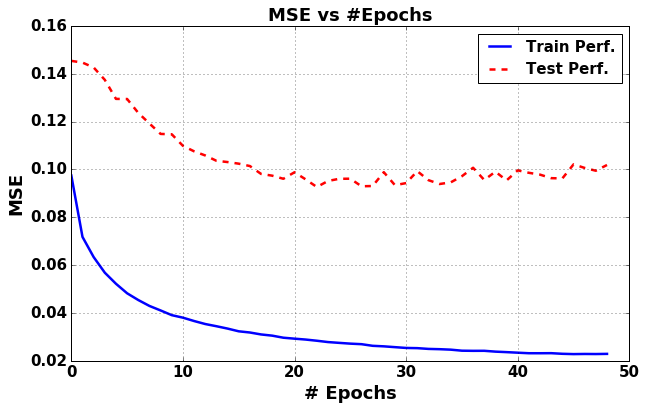

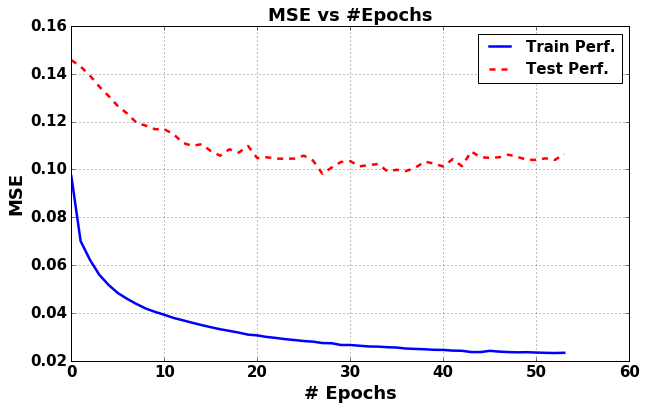

In [9]:
analysisName = 'mse'

# plot train updates
import matplotlib.pyplot as plt
%matplotlib inline  

for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig1 = plt.figure(figsize=(10,6))

    base_name = files_results_path+'/'+choose_date+'_'

    load_file_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(load_file_name)

    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    if model.loss == 'mean_squared_error':
        cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    
    # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)

In [10]:
base_name = files_results_path+'/'+choose_date+'_'
mean_val_acc = {}
variance_val_acc = {}

print '\tMean of val_acc\t\tVariance of val_acc'
for ifold in range(train_info['n_folds']):
    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)
    
    mean_val_acc[ifold] = np.mean(trn_desc['val_acc'])
    variance_val_acc[ifold] = np.var(trn_desc['val_acc'])
    print 'Fold %i: %.2f%%\t\t%.2f%%'%(ifold,    100*mean_val_acc[ifold], 100*variance_val_acc[ifold])


	Mean of val_acc		Variance of val_acc
Fold 0: 74.07%		0.03%
Fold 1: 72.04%		0.03%
Fold 2: 71.61%		0.07%
Fold 3: 70.41%		0.03%


Results for fold #0
Results for fold #1
Results for fold #2
Results for fold #3


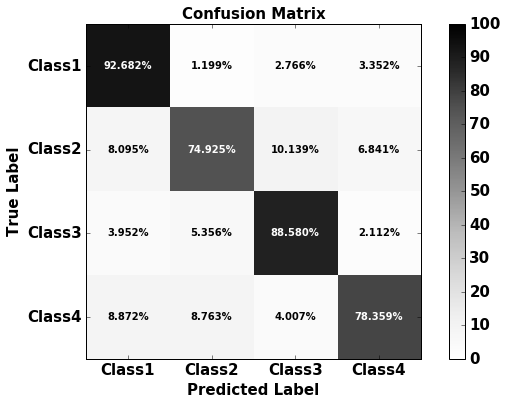

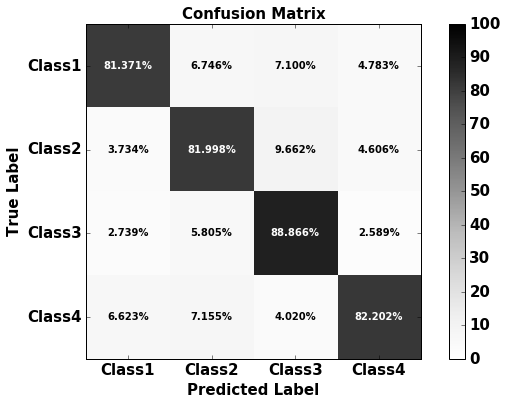

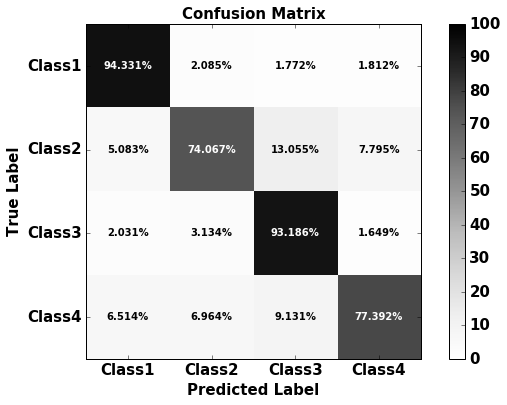

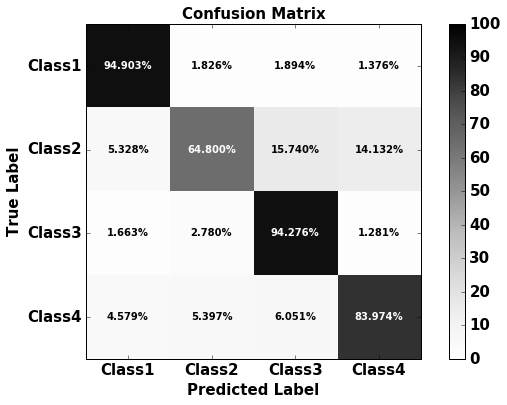

In [11]:
from sklearn import preprocessing

analysisName = 'confusion_matrix'

import matplotlib.pyplot as plt
%matplotlib inline  
for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # read trained model
    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    train_id, test_id = train_info['CVO'][ifold]

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)

    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)

    output = model.predict(norm_all_data)
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)

Results for fold #0
Results for fold #1
Results for fold #2
Results for fold #3


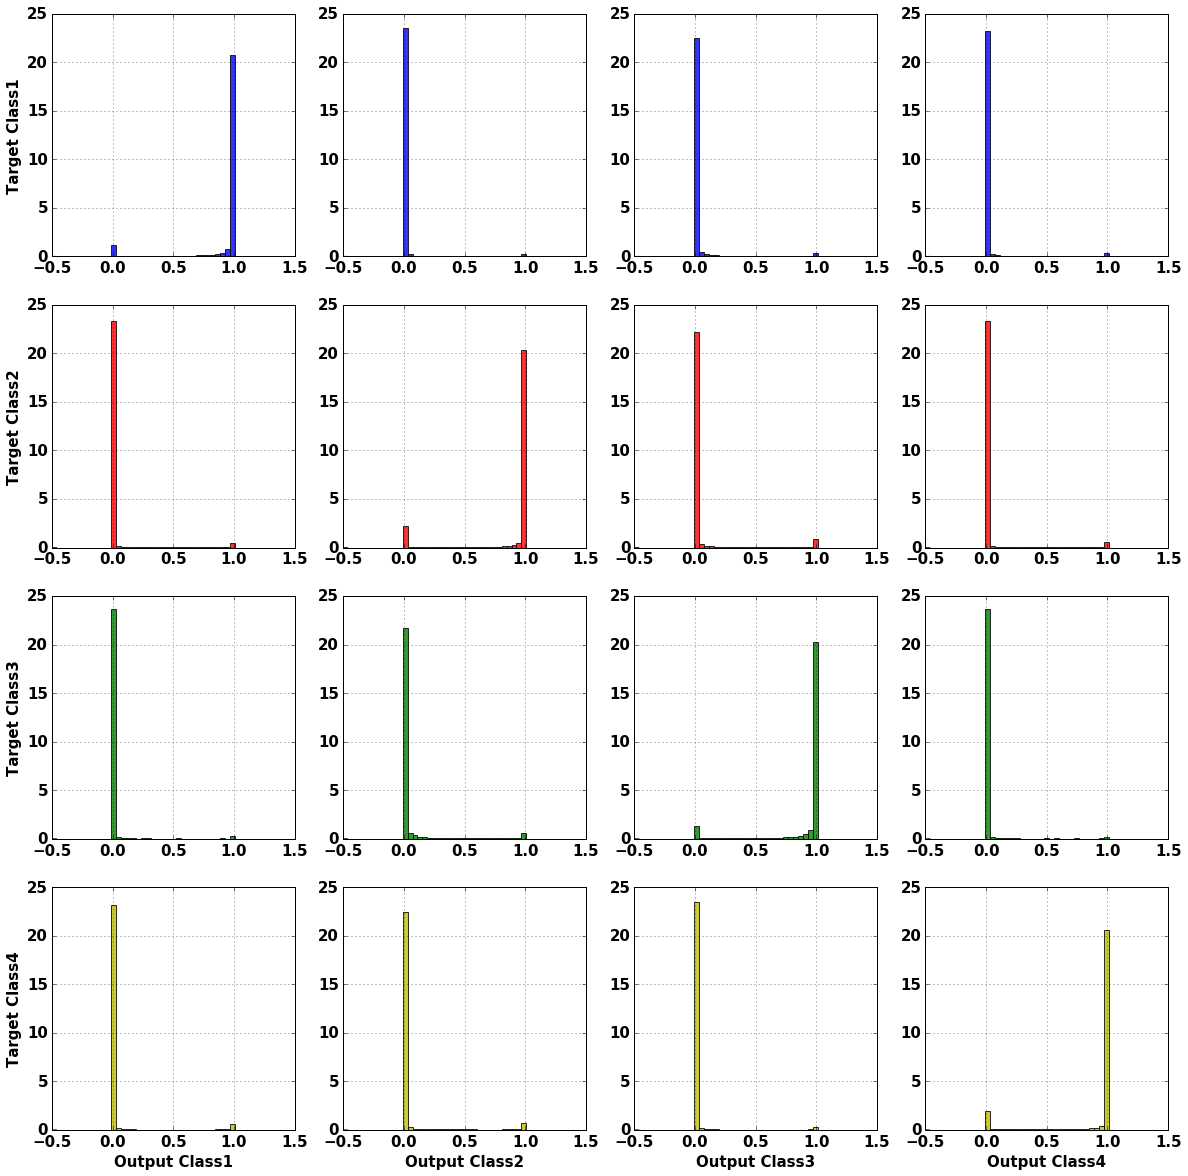

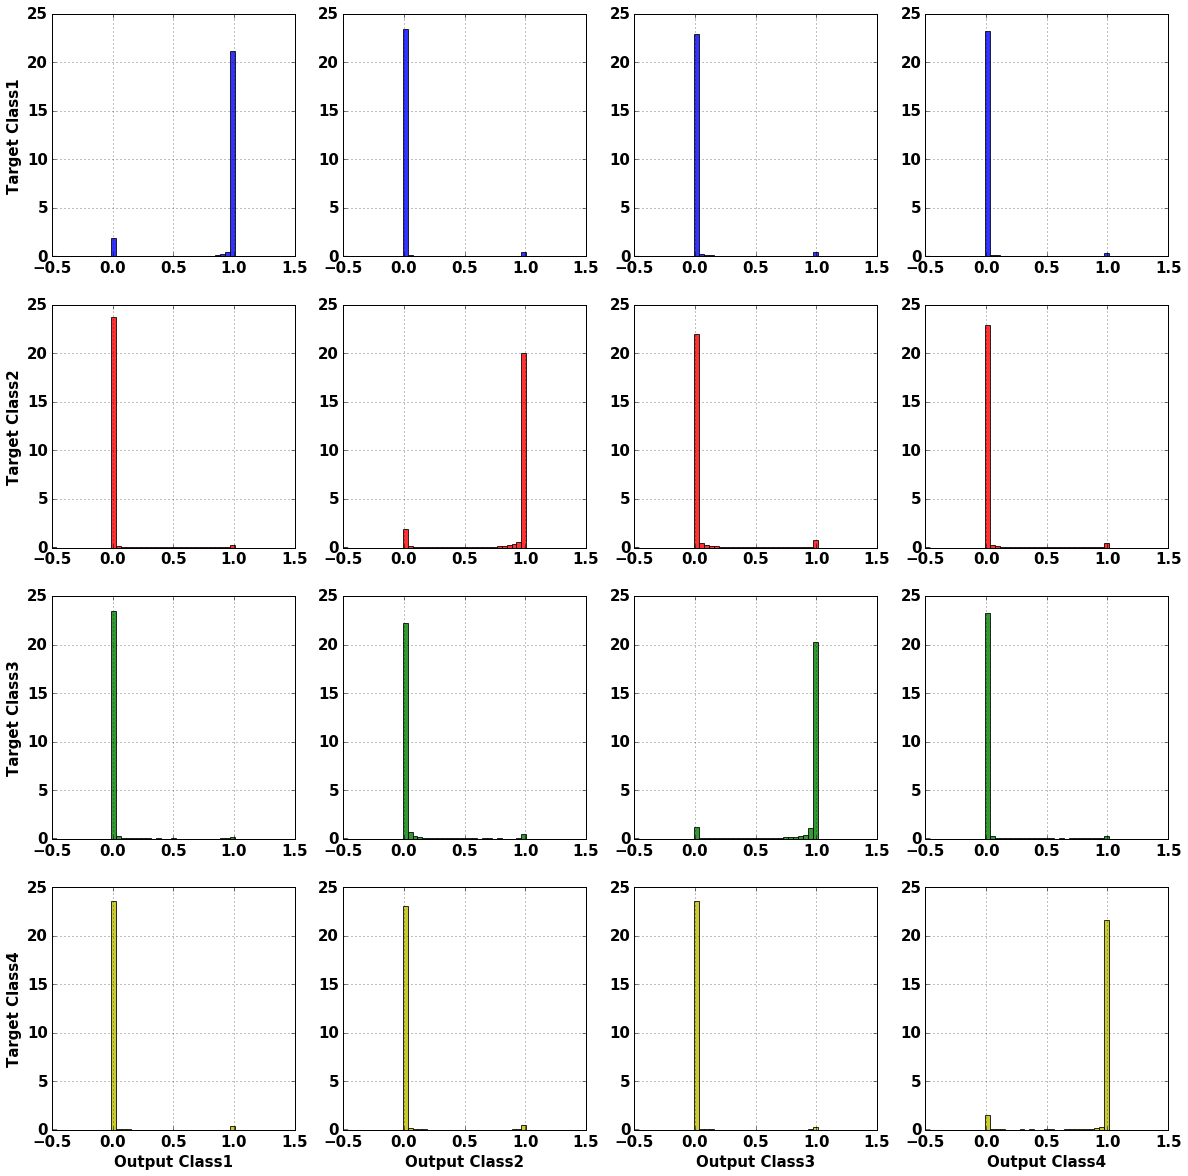

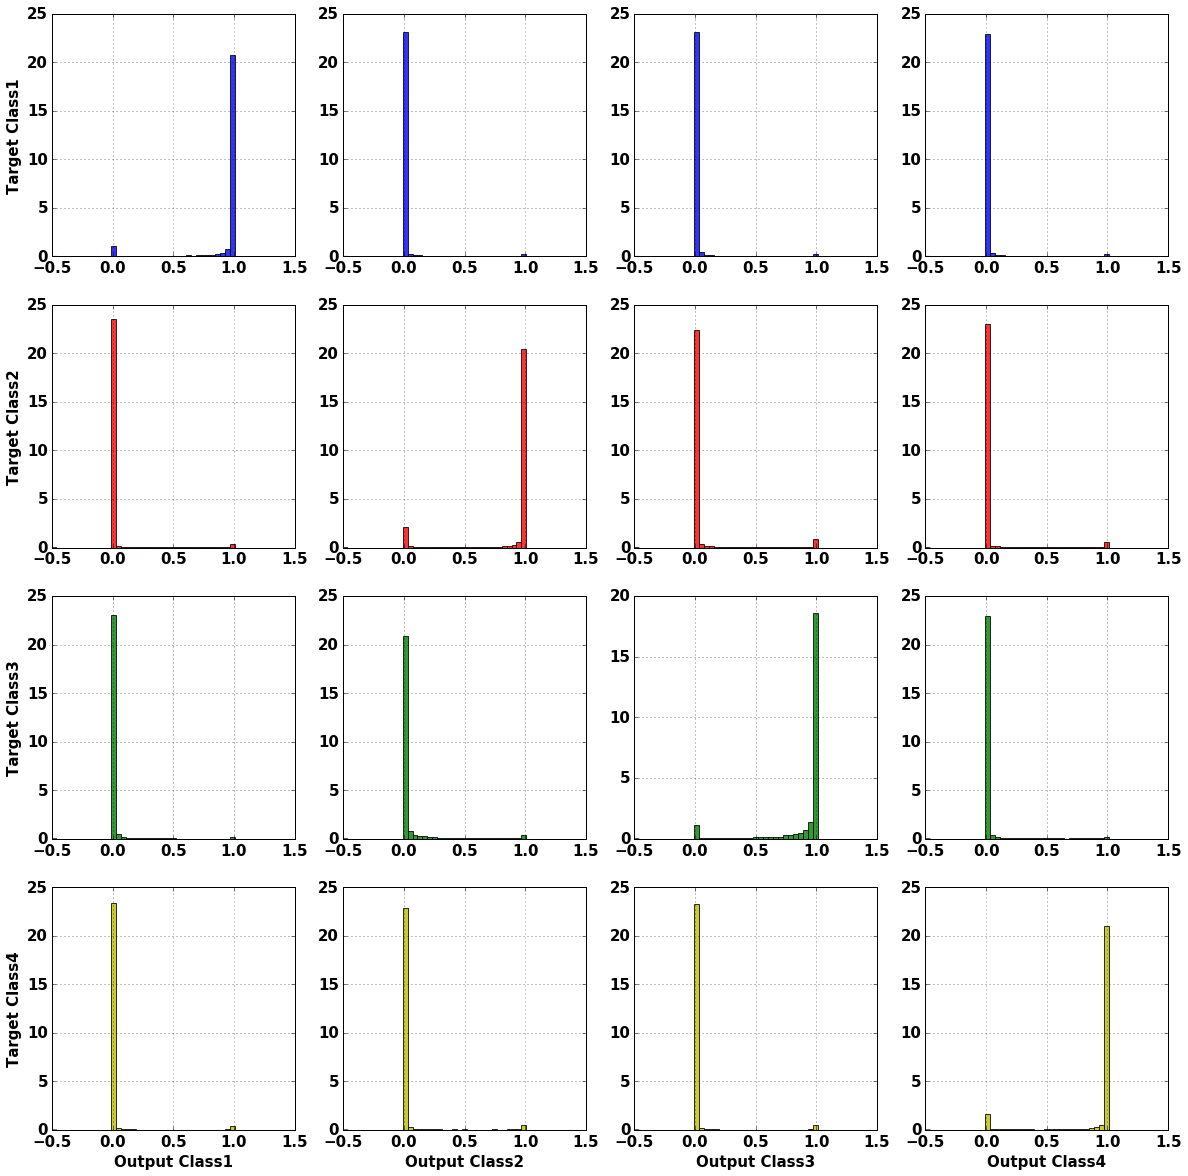

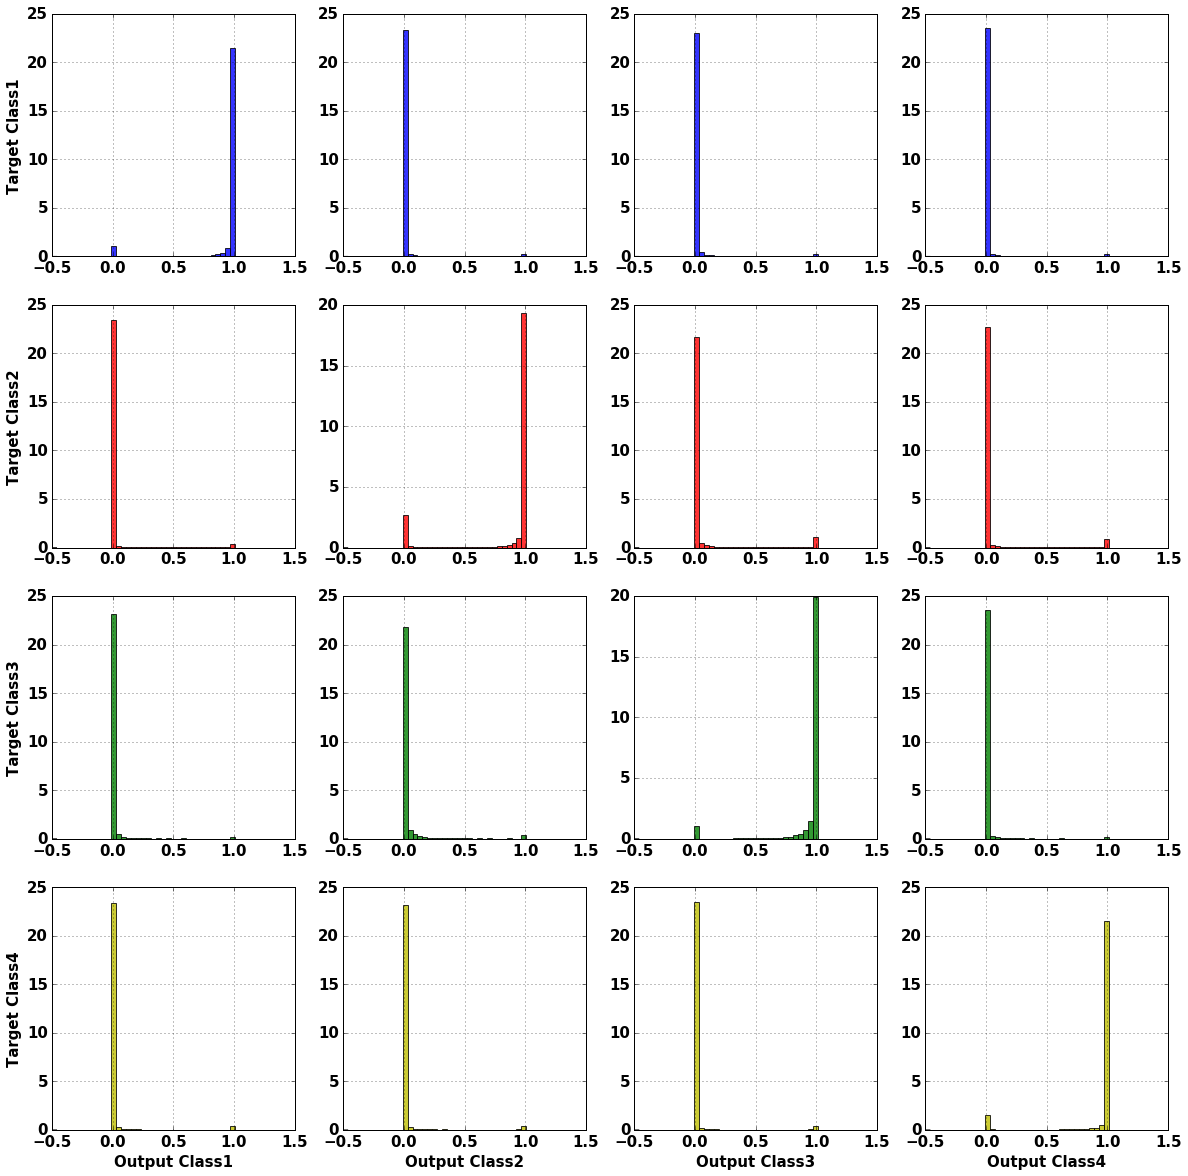

In [12]:
analysisName = 'histogram'

import matplotlib.pyplot as plt
%matplotlib inline  

for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)

    labels = class_labels.values()

    # read trained model

    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)
    
    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)

    output = model.predict(norm_all_data)

    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse.shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=1)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
       # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)


Results for fold #0
Results for fold #1
Results for fold #2
Results for fold #3


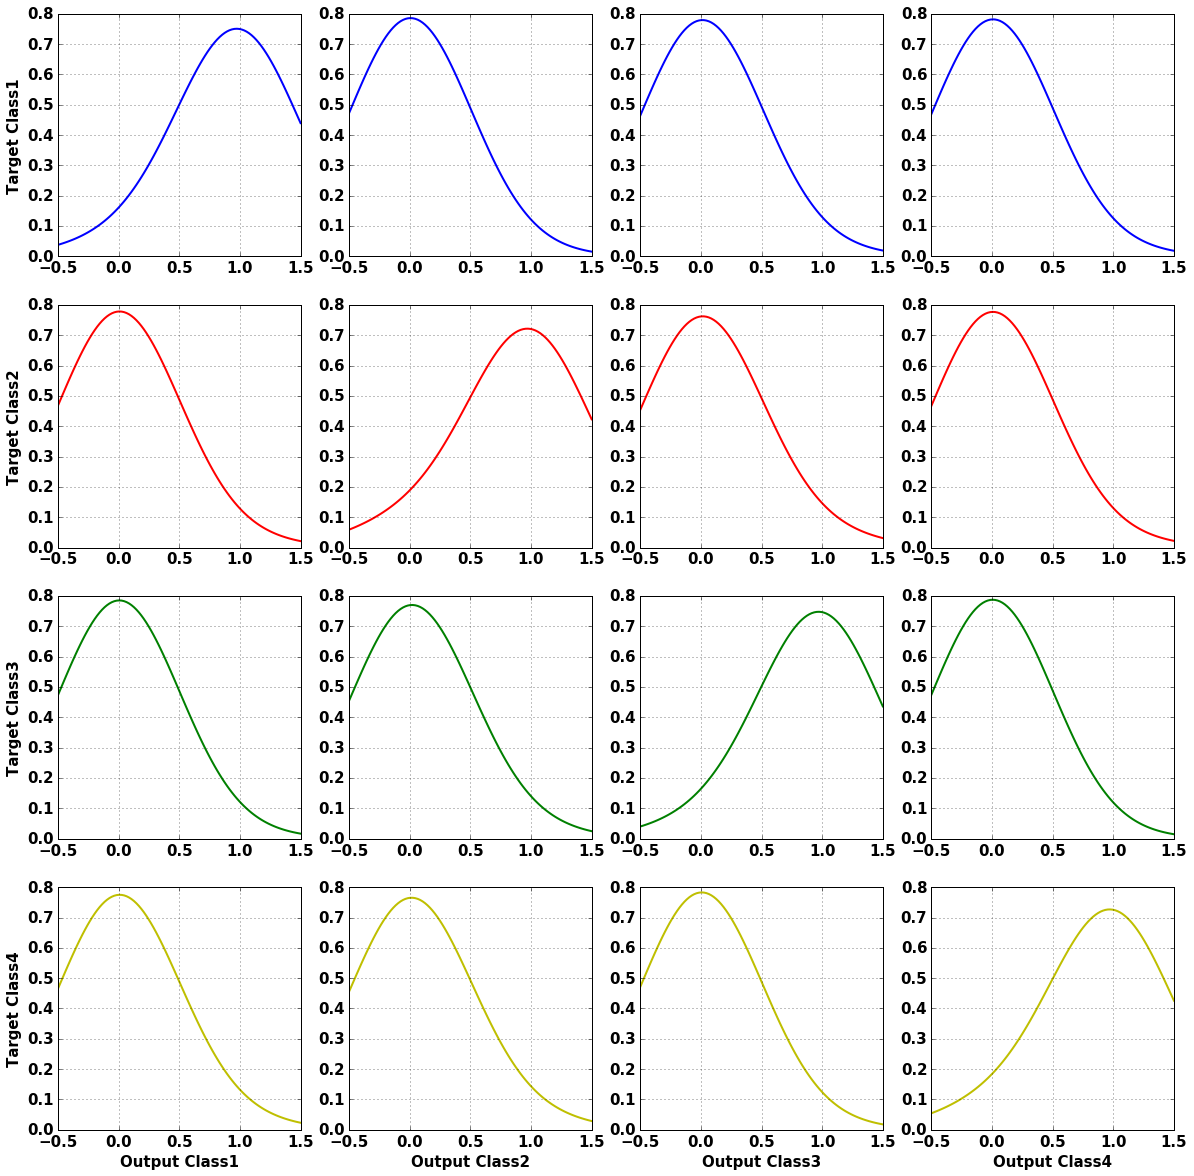

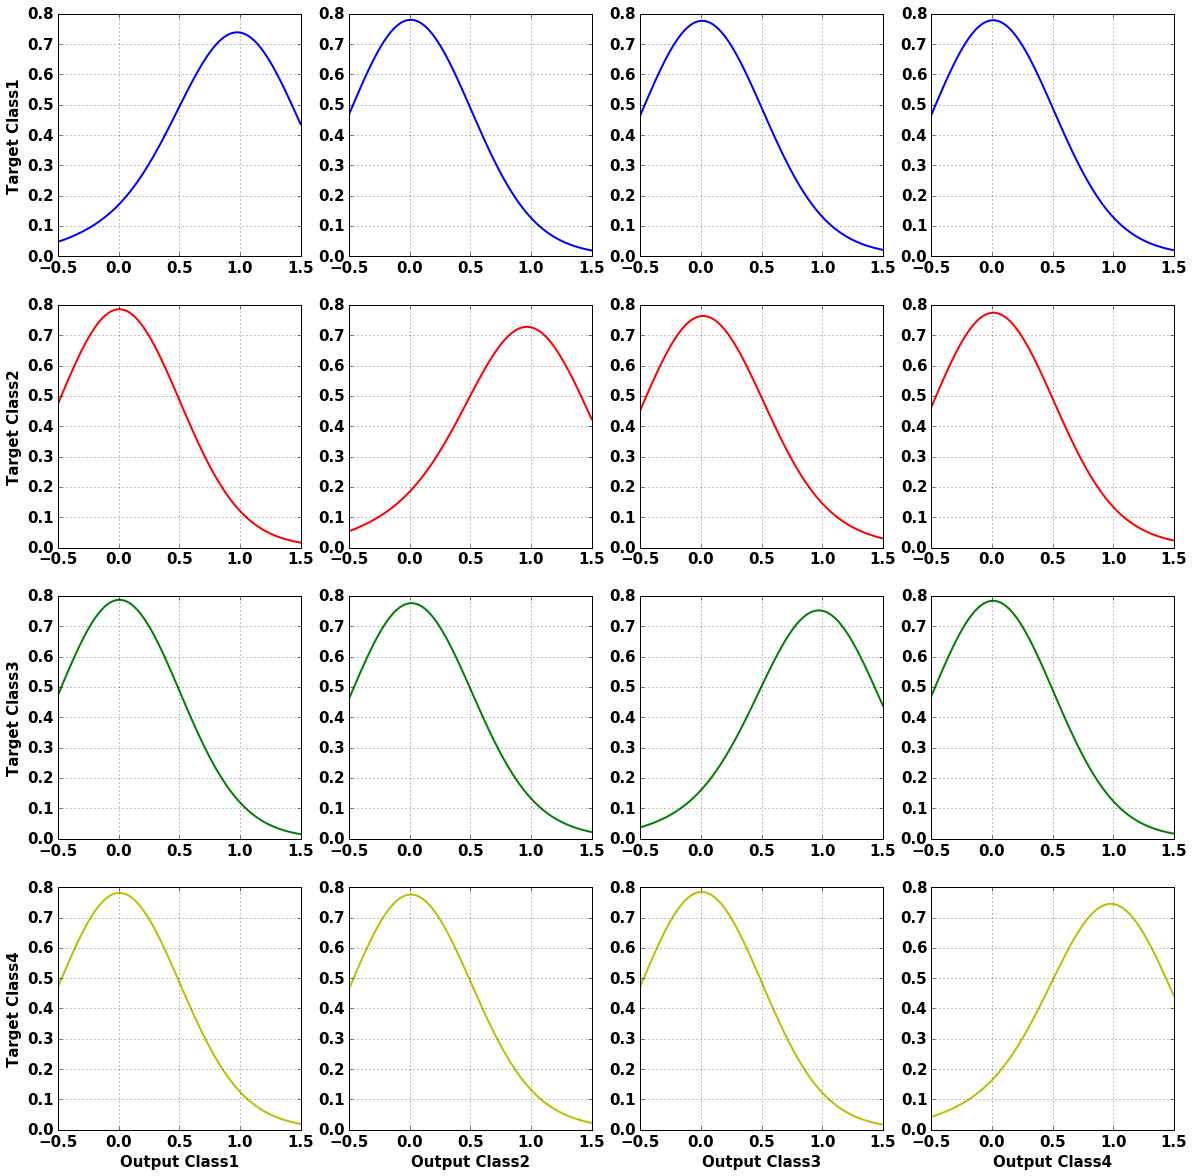

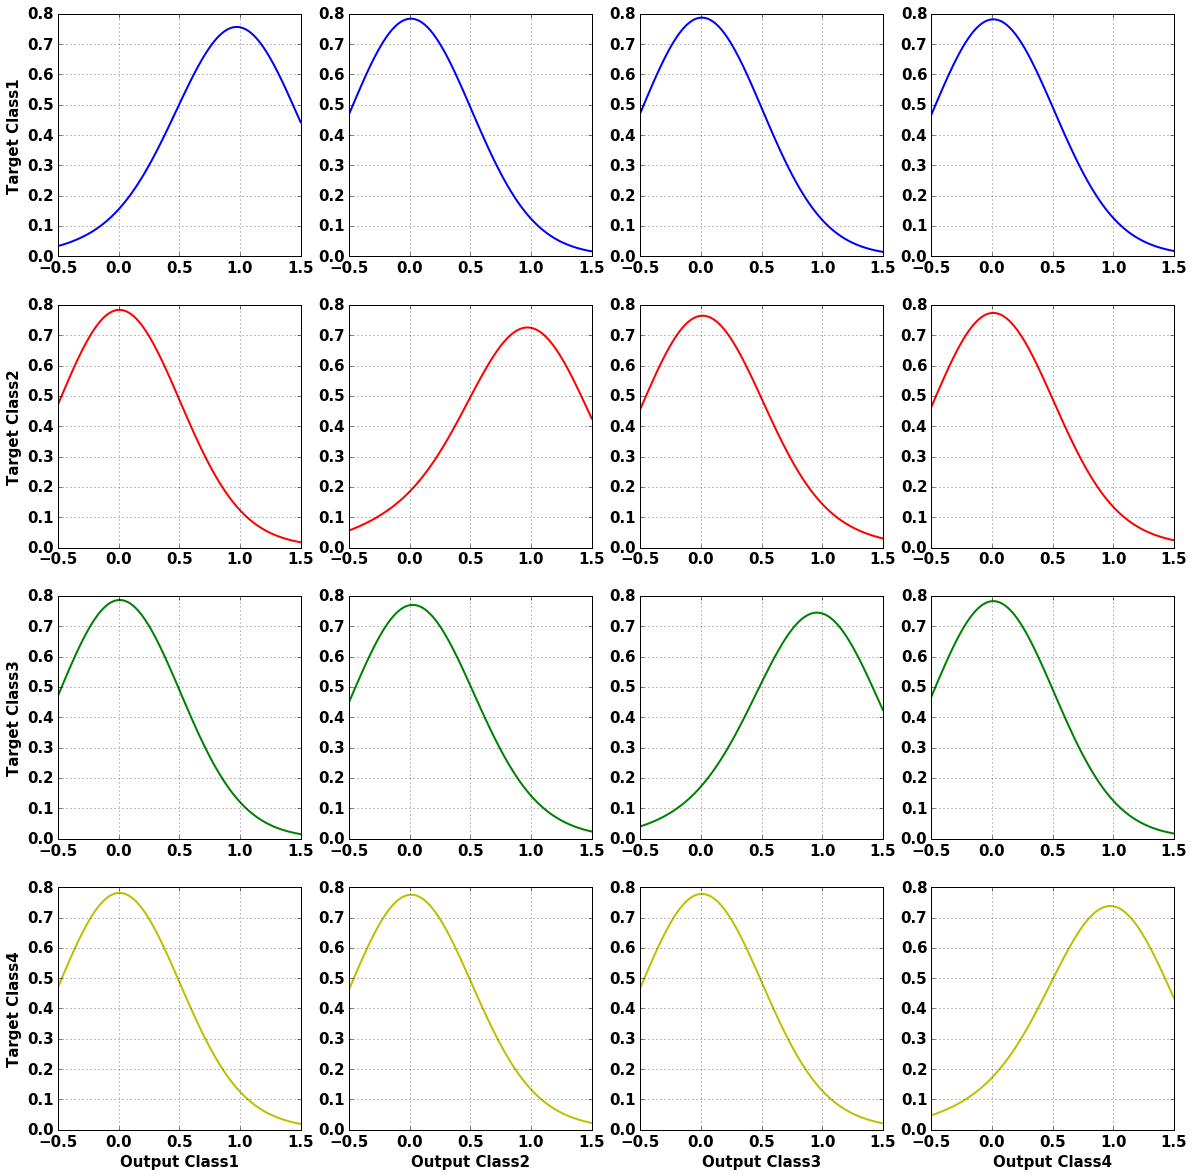

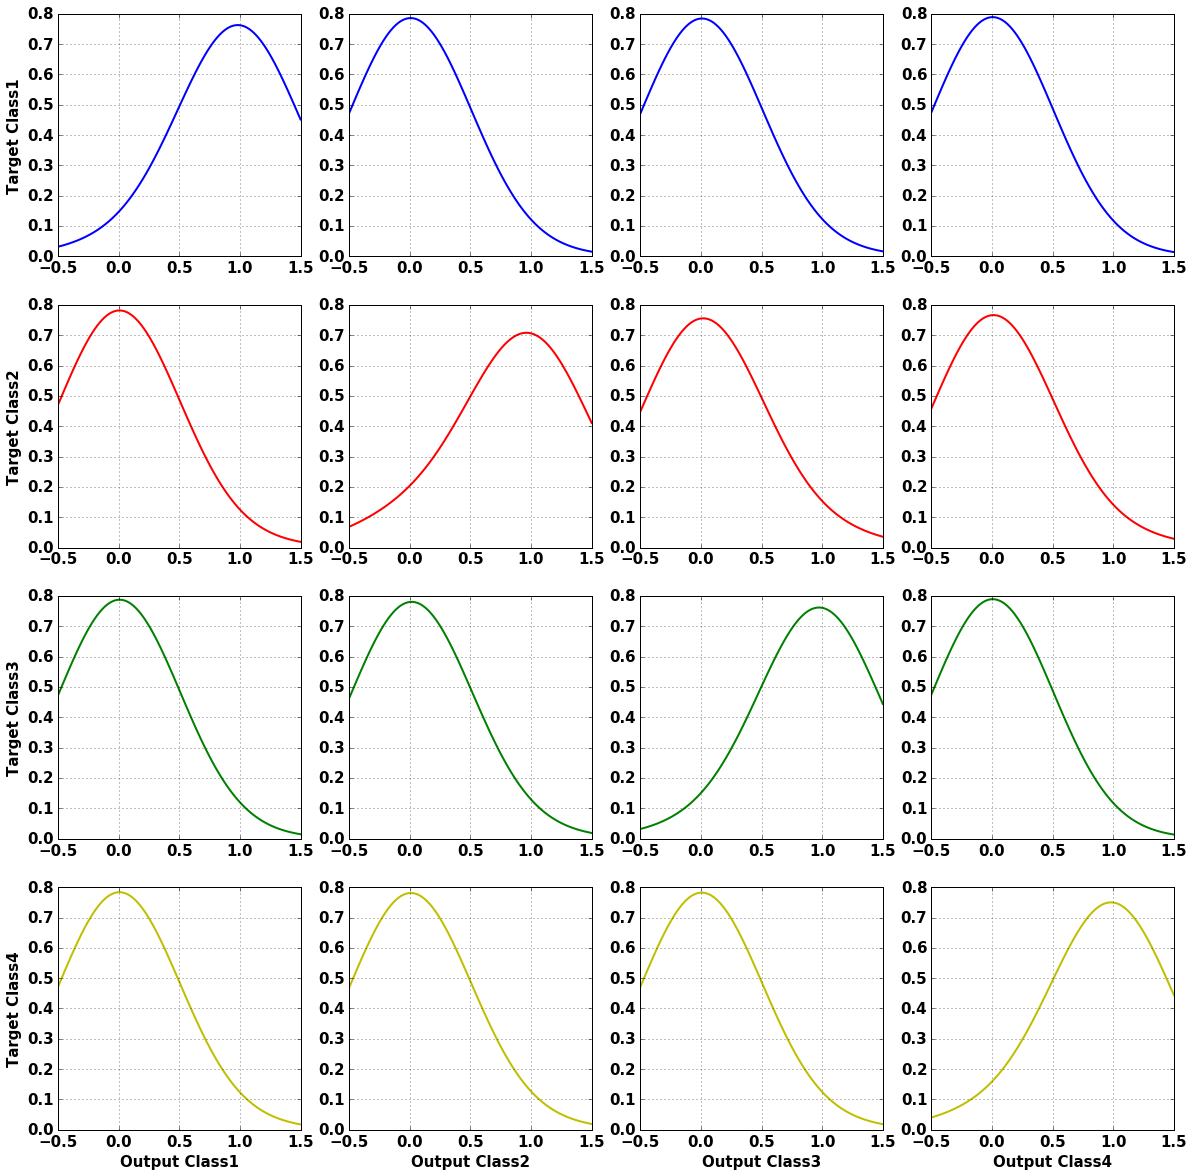

In [13]:
analysisName = 'kernel_density'

import matplotlib.pyplot as plt
%matplotlib inline  
for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)

    labels = class_labels.values()

    # read trained model
    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)
    
    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)
    
    output = model.predict(norm_all_data)

    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse.shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
   # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)

In [50]:
# Classification Report
import keras
from keras import backend as K
import sklearn.metrics

print 'Showing results for train performed on %s:'%choose_date
for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    print "Results for Fold #%i"%ifold
    # read trained model
    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)
     # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)
    
    
    output = model.predict(all_data[test_id])
    
    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = sklearn.metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    #print sklearn.metrics.classification_report(trgt_sparse[test_id], np.round(output), target_names=class_labels.values())

Showing results for train performed on 2017_08_07_11_05_17:
Results for Fold #0
Class1:	0.894317	0.718452	0.796796
Class2:	0.743440	0.660262	0.699387
Class3:	0.775724	0.766421	0.771045
Class4:	0.692836	0.784137	0.735665
Results for Fold #1
Class1:	0.874434	0.578904	0.696622
Class2:	0.798963	0.692696	0.742044
Class3:	0.761201	0.625102	0.686471
Class4:	0.643761	0.880894	0.743886
Results for Fold #2
Class1:	0.942476	0.616244	0.745221
Class2:	0.772198	0.660125	0.711777
Class3:	0.806334	0.572499	0.669589
Class4:	0.605809	0.895339	0.722653
Results for Fold #3
Class1:	0.939839	0.636549	0.759019
Class2:	0.836946	0.484056	0.613366
Class3:	0.723870	0.774871	0.748503
Class4:	0.597388	0.847642	0.700845
